In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import rpy2.robjects as ro
from rpy2.robjects.packages import importr

In [36]:
base = importr('base')

This note book demonstrates various methods to measure correlations between data (numerical and categorical), both in Python and in R. 

(Still under heavy construction.)

# Make data

In [37]:
N = 1000

## Numericals

In [38]:
numerical_1 = np.random.uniform(0, 1, N)
numerical_2 = numerical_1 + 0.1*np.random.randn(N)

numerical_1_r = ro.FloatVector(numerical_1)
numerical_2_r = ro.FloatVector(numerical_2)

## Categoricals

In [39]:
def generate_rints(num_categories, N):
    rint_1 = np.random.randint(0, num_categories, N)
    rint_2 = rint_1.copy()
    
    for i in range(len(rint_1)):
        if np.random.uniform(0, 1)>0.9:
            rint_2[i]=np.random.randint(0, num_categories, 1)
    return rint_1, rint_2

### Binary

In [40]:
rint_binary_1, rint_binary_2 = generate_rints(2, N)

rint_binary_1_r = ro.IntVector(rint_binary_1)
rint_binary_2_r = ro.IntVector(rint_binary_2)
        
categorical_binary_1 = [str(i) for i in rint_binary_1]
categorical_binary_2 = [str(i) for i in rint_binary_2] 

categorical_binary_1_r = ro.FactorVector(categorical_binary_1)
categorical_binary_2_r = ro.FactorVector(categorical_binary_2)

### Multiple 

In [41]:
rint_multi_1, rint_multi_2 = generate_rints(5, N)

rint_multi_1_r = ro.IntVector(rint_multi_1)
rint_multi_2_r = ro.IntVector(rint_multi_2)
        
categorical_multi_1 = [str(i) for i in rint_multi_1]
categorical_multi_2 = [str(i) for i in rint_multi_1] 

categorical_multi_1_r = ro.FactorVector(categorical_multi_1)
categorical_multi_2_r = ro.FactorVector(categorical_multi_2)

## Correlated numerical and categorical

In [42]:
numerical_3 = np.array([np.random.normal(0, 1) if c==0 else np.random.normal(1, 1) for c in rint_binary_2])
numerical_3_r = ro.FloatVector(numerical_3)

In [43]:
numerical_3 = np.array([np.random.normal(0, 1) if c==0 else np.random.normal(1, 1) for c in rint_binary_2])
numerical_3_r = ro.FloatVector(numerical_3)

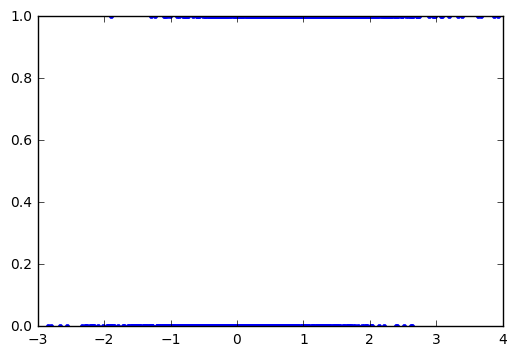

In [44]:
plt.plot(numerical_3, rint_binary_2, '.');

# Numerical v.s. numerical

## Pearson correlation coefficient

In [45]:
scipy.stats.pearsonr(numerical_1, numerical_2)

(0.94693699325274561, 0.0)

In [46]:
print ro.r.cor(numerical_1_r, numerical_2_r)

[1] 0.946937



# numerical v.s. categorical

## ttest

### Correlated

In [47]:
numerical_3_0 = numerical_3[np.where(rint_binary_2==0)]
numerical_3_1 = numerical_3[np.where(rint_binary_2==1)]
scipy.stats.ttest_ind(numerical_3_0, numerical_3_1, axis=0, equal_var=True)

Ttest_indResult(statistic=-16.77756919550502, pvalue=7.6699889529633761e-56)

In [55]:
numerical_3_0_r = ro.FloatVector(numerical_3_0)
numerical_3_1_r = ro.FloatVector(numerical_3_1)
res = ro.r('t.test')(numerical_3_0_r, numerical_3_1_r)
res.names.r_repr()
print res[res.names.index('statistic')]

'c("statistic", "parameter", "p.value", "conf.int", "estimate", \n"null.value", "alternative", "method", "data.name")'

        t 
-16.78542 



### Uncorrelated

In [49]:
scipy.stats.ttest_ind(numerical_2[np.where(rint_binary_2==0)], numerical_2[np.where(rint_binary_2==1)], axis=0, equal_var=True)

Ttest_indResult(statistic=-1.7435508702892273, pvalue=0.081545363139403138)

In [50]:
scipy.stats.f_oneway(numerical_3[np.where(rint_binary_2==0)], numerical_3[np.where(rint_binary_2==1)])

F_onewayResult(statistic=281.48682810995905, pvalue=7.6699889529665936e-56)

## Analysis of Variance

### Interesting case

In [51]:
df = ro.DataFrame({'num':numerical_3_r, 'cat': categorical_binary_2_r})
aov_res = ro.r('aov')(ro.Formula('num~cat'), df)
print base.summary(aov_res)

             Df Sum Sq Mean Sq F value Pr(>F)    
cat           1  276.5  276.49   281.5 <2e-16 ***
Residuals   998  980.3    0.98                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [52]:
scipy.stats.f_oneway(numerical_2[np.where(rint_binary_2==0)], numerical_2[np.where(rint_binary_2==1)])

F_onewayResult(statistic=3.0399696372863128, pvalue=0.081545363139449031)

### Uninteresting case

In [53]:
df = ro.DataFrame({'num':numerical_2_r, 'cat': categorical_binary_2_r})
aov_res = ro.r('aov')(ro.Formula('num~cat'), df)
print base.summary(aov_res)

             Df Sum Sq Mean Sq F value Pr(>F)  
cat           1   0.28 0.27859    3.04 0.0815 .
Residuals   998  91.46 0.09164                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [64]:
res = ro.r('chisq.test')(categorical_binary_1_r, categorical_binary_2_r)
res.names.r_repr()
print res[res.names.index('statistic')]
print res[res.names.index('p.value')]

'c("statistic", "parameter", "p.value", "method", "data.name", \n"observed", "expected", "residuals", "stdres")'

X-squared 
 810.0637 

[1] 3.499772e-178



Ref: http://stats.stackexchange.com/questions/108007/correlations-with-categorical-variables